In [1]:
# Cell 1: Imports
import os
import glob
import pandas as pd
import numpy as np
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import csv

In [2]:
# Cell 2: Load the Datasets and Fix Test Column Order
train_files = glob.glob(os.path.join("Data", "Train", "*.csv"))
test_files = glob.glob(os.path.join("Data", "Test", "*.csv"))

if len(train_files) == 0:
    raise FileNotFoundError("No training CSV files found in Data/Train")
if len(test_files) == 0:
    raise FileNotFoundError("No testing CSV files found in Data/Test")

# Read training files (using default CSV settings)
train_dfs = []
for file in train_files:
    try:
        df = pd.read_csv(file, engine='python')
        train_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")
train_df = pd.concat(train_dfs, ignore_index=True)

# Read testing files
test_dfs = []
for file in test_files:
    try:
        df = pd.read_csv(file, engine='python')
        test_dfs.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")
test_df = pd.concat(test_dfs, ignore_index=True)

# Fix test_df column order if necessary.
if test_df.columns[0].strip().lower() == "label":
    test_df = test_df[["Statement", "Label"]]

print("Training dataset shape:", train_df.shape)
print("Testing dataset shape:", test_df.shape)

Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_000.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_001.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_002.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_003.csv: ',' expected after '"'
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_005.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_006.csv: ',' expected after '"'
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_007.csv: Expected 2 fields in line 330, saw 3
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_010.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_012.csv: unexpected end of data
Error reading Data/Train/fulltrain_Guardian_Nyt_binary_shuffled_013.csv: ',' expected after '"'
Error reading Data/Train/f

In [3]:
# Cell 3: Handle Missing Values Precisely
# Drop rows where the 'Statement' column is empty after stripping whitespace.
train_df = train_df[train_df["Statement"].astype(str).str.strip() != ""]
test_df = test_df[test_df["Statement"].astype(str).str.strip() != ""]

print("Processed Training dataset shape:", train_df.shape)
print("Processed Testing dataset shape:", test_df.shape)

Processed Training dataset shape: (28633, 2)
Processed Testing dataset shape: (7011, 2)


In [4]:
# Cell 4: Extract Features and Labels
X_train = train_df["Statement"]
y_train = train_df["Label"]

X_test = test_df["Statement"]
y_test = test_df["Label"]

# (Optional) Verify with an example:
print("Example training statement:", X_train.iloc[0])

Example training statement: Sainsburyâ€™s sales have dropped further after it was forced to cut prices amid heavy competition from discount rivals. Sales at stores open for more than a year fell by 1.1% in the three months to 24 September, compared with the 0.8% decline reported for the previous three months. Shares in Sainsburyâ€™s slid 3.5% to 242.2p in morning trading, as City analysts said the supermarket had slightly underperformed against expectations and appeared to be under more pressure in comparison with Morrisons and Tesco. Mike Coupe, Sainsburyâ€™s chief executive, said the fall in sales was driven by price cuts. Although a 1% dip in prices resulted in a drop in the total value of Sainsburyâ€™s sales in the quarter, the reductions drew more people to Sainsburyâ€™s tills and meant the group sold a higher volume of goods. Coupe said there had been no discernible impact on customer behaviour after the EU referendum, and he thought there would not be any impact on shopping unle

In [5]:
# Cell 4.1: Clean and Shuffle the Data
# Keep only binary labels (0 or 1)
train_df = train_df[train_df['Label'].isin([0, 1])]
test_df = test_df[test_df['Label'].isin([0, 1])]

# Convert the Label columns to integers.
train_df['Label'] = train_df['Label'].astype(int)
test_df['Label'] = test_df['Label'].astype(int)

# Shuffle the data.
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Re-extract features and labels after cleaning.
X_train = train_df['Statement']
y_train = train_df['Label']
X_test = test_df['Statement']
y_test = test_df['Label']

In [6]:
# Cell 5: Preprocess Text for the LSTM
def tokenize(text):
    # Convert text to lowercase and extract word tokens.
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary from the training statements.
all_tokens = []
for text in X_train:
    all_tokens.extend(tokenize(text))
    
# Limit vocabulary to the 10,000 most common words.
max_vocab = 10000
freq = Counter(all_tokens)
vocab = {word: i+2 for i, (word, count) in enumerate(freq.most_common(max_vocab))}
vocab_size = len(vocab) + 2  # Reserve 0 for padding, 1 for unknown.

def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, 1) for token in tokens]

# Convert texts to sequences of token indices.
X_train_seq = [text_to_sequence(text, vocab) for text in X_train]
X_test_seq = [text_to_sequence(text, vocab) for text in X_test]

# Set fixed maximum sequence length.
max_len = 300

def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

# Apply padding/truncation.
X_train_pad = [pad_sequence(seq, max_len) for seq in X_train_seq]
X_test_pad = [pad_sequence(seq, max_len) for seq in X_test_seq]

In [7]:
# Cell 6: Convert Sequences to Torch Tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)

y_train_tensor = torch.tensor(y_train.astype(int).values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.astype(int).values, dtype=torch.long)

In [8]:
# Cell 7: Create a PyTorch Dataset and DataLoader
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

batch_size = 64
train_dataset = NewsDataset(X_train_tensor, y_train_tensor)
test_dataset = NewsDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [9]:
# Cell 8: Create a Validation Split from the Training Dataset
total_train = len(train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"New train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

New train set size: 18515, Validation set size: 4628


In [10]:
# Cell 9: Augmentation Setup and Redefinition of the NewsDataset with Augmentation
def augment_sequence(seq, drop_prob=0.1):
    # Randomly replace tokens (except padding tokens) with the unknown token (index 1).
    return [token if token == 0 or np.random.rand() > drop_prob else 1 for token in seq]

class NewsDataset(Dataset):
    def __init__(self, texts, labels, augment=False, drop_prob=0.1):
        self.texts = texts
        self.labels = labels
        self.augment = augment
        self.drop_prob = drop_prob
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if self.augment:
            text_list = text.tolist()
            text_list = augment_sequence(text_list, drop_prob=self.drop_prob)
            text = torch.tensor(text_list, dtype=torch.long)
        return text, label

# Re-create datasets with augmentation enabled for training.
train_dataset = NewsDataset(X_train_tensor, y_train_tensor, augment=True, drop_prob=0.1)
total_train = len(train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [11]:
# Cell 10: Pretrain the LSTM Autoencoder
class LSTMAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim):
        super(LSTMAutoencoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_enc = nn.Linear(hidden_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder(embedded)
        latent = self.fc_enc(hidden[-1])
        hidden_dec = self.fc_dec(latent).unsqueeze(0)
        cell_dec = torch.zeros_like(hidden_dec)
        dec_out, _ = self.decoder(embedded, (hidden_dec, cell_dec))
        reconstructed = self.output_layer(dec_out)
        return latent, reconstructed

# Hyperparameters for pretraining.
pretrain_epochs = 6
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
embedding_dim = 100
hidden_dim = 128
latent_dim = 64

autoencoder = LSTMAutoencoder(vocab_size, embedding_dim, hidden_dim, latent_dim)
autoencoder.to(device)

criterion_recon = nn.CrossEntropyLoss(ignore_index=0)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)
best_recon_loss = float('inf')

for epoch in range(pretrain_epochs):
    autoencoder.train()
    running_loss = 0.0
    for texts, _ in train_loader:  # No labels needed for autoencoder pretraining.
        texts = texts.to(device)
        optimizer_ae.zero_grad()
        _, reconstructed = autoencoder(texts)
        loss = criterion_recon(reconstructed.view(-1, vocab_size), texts.view(-1))
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * texts.size(0)
    avg_loss = running_loss / len(train_dataset)
    print(f"Autoencoder Pretrain Epoch {epoch+1}/{pretrain_epochs} - Loss: {avg_loss:.4f}")
    if avg_loss < best_recon_loss:
        best_recon_loss = avg_loss
        best_autoencoder_state = autoencoder.state_dict()

autoencoder.load_state_dict(best_autoencoder_state)

Autoencoder Pretrain Epoch 1/6 - Loss: 4.0485
Autoencoder Pretrain Epoch 2/6 - Loss: 0.8805
Autoencoder Pretrain Epoch 3/6 - Loss: 0.2389
Autoencoder Pretrain Epoch 4/6 - Loss: 0.0736
Autoencoder Pretrain Epoch 5/6 - Loss: 0.0293
Autoencoder Pretrain Epoch 6/6 - Loss: 0.0156


<All keys matched successfully>

In [12]:
# Cell 11: Two‑Phase Joint Training with Validation, Early Stopping, and Alpha Scheduling
class JointLSTMAutoencoderClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, output_dim):
        super(JointLSTMAutoencoderClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_enc = nn.Linear(hidden_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder(embedded)
        latent = self.fc_enc(hidden[-1])
        class_output = self.classifier(latent)
        hidden_dec = self.fc_dec(latent).unsqueeze(0)
        cell_dec = torch.zeros_like(hidden_dec)
        dec_out, _ = self.decoder(embedded, (hidden_dec, cell_dec))
        reconstructed = self.output_layer(dec_out)
        return latent, reconstructed, class_output

# Update latent dimension if needed.
latent_dim = 128

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # Binary classification

joint_model = JointLSTMAutoencoderClassifier(vocab_size, embedding_dim, hidden_dim, latent_dim, output_dim)
joint_model.to(device)

#=== Phase 1: Freeze encoder and embedding ===#
for param in joint_model.encoder.parameters():
    param.requires_grad = False
joint_model.embedding.weight.requires_grad = False

criterion_recon = nn.CrossEntropyLoss(ignore_index=0)
criterion_cls = nn.CrossEntropyLoss()
optimizer_joint = optim.Adam(joint_model.parameters(), lr=0.001)

patience = 3
best_val_acc = 0.0
patience_counter = 0

phase1_epochs = 5
phase2_epochs = 8
initial_alpha = 0.5

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

total_epochs = phase1_epochs + phase2_epochs

for epoch in range(total_epochs):
    if epoch == phase1_epochs:
        print("Unfreezing encoder and embedding layer for Phase 2...")
        for param in joint_model.encoder.parameters():
            param.requires_grad = True
        joint_model.embedding.weight.requires_grad = True
    
    current_alpha = initial_alpha * (0.9 ** epoch)
    joint_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        optimizer_joint.zero_grad()
        latent, reconstructed, class_output = joint_model(texts)
        loss_recon = criterion_recon(reconstructed.view(-1, vocab_size), texts.view(-1))
        loss_cls = criterion_cls(class_output, labels)
        loss = loss_recon + current_alpha * loss_cls
        loss.backward()
        optimizer_joint.step()
        running_loss += loss.item() * texts.size(0)
        _, predicted = torch.max(class_output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    train_loss = running_loss / total_train
    train_acc = correct_train / total_train
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f"Epoch {epoch+1}/{total_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Alpha: {current_alpha:.4f}")
    
    joint_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            _, _, class_output = joint_model(texts)
            loss_val = criterion_cls(class_output, labels)
            val_loss += loss_val.item() * texts.size(0)
            _, predicted_val = torch.max(class_output, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    avg_val_loss = val_loss / total_val
    val_acc = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_acc)
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = joint_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/13 - Train Loss: 4.4687 - Train Acc: 0.6320 - Alpha: 0.5000
Validation Loss: 0.6379 - Validation Acc: 0.6571
Epoch 2/13 - Train Loss: 1.2766 - Train Acc: 0.6555 - Alpha: 0.4500
Validation Loss: 0.6271 - Validation Acc: 0.6692
Epoch 3/13 - Train Loss: 0.5417 - Train Acc: 0.6649 - Alpha: 0.4050
Validation Loss: 0.6219 - Validation Acc: 0.6711
Epoch 4/13 - Train Loss: 0.3235 - Train Acc: 0.6619 - Alpha: 0.3645
Validation Loss: 0.6247 - Validation Acc: 0.6713
Epoch 5/13 - Train Loss: 0.2432 - Train Acc: 0.6676 - Alpha: 0.3281
Validation Loss: 0.6231 - Validation Acc: 0.6720
Unfreezing encoder and embedding layer for Phase 2...
Epoch 6/13 - Train Loss: 0.1997 - Train Acc: 0.6697 - Alpha: 0.2952
Validation Loss: 0.4464 - Validation Acc: 0.7893
Epoch 7/13 - Train Loss: 0.1098 - Train Acc: 0.8345 - Alpha: 0.2657
Validation Loss: 0.3613 - Validation Acc: 0.8423
Epoch 8/13 - Train Loss: 0.1023 - Train Acc: 0.8314 - Alpha: 0.2391
Validation Loss: 0.3608 - Validation Acc: 0.8375
Epoch 9/13

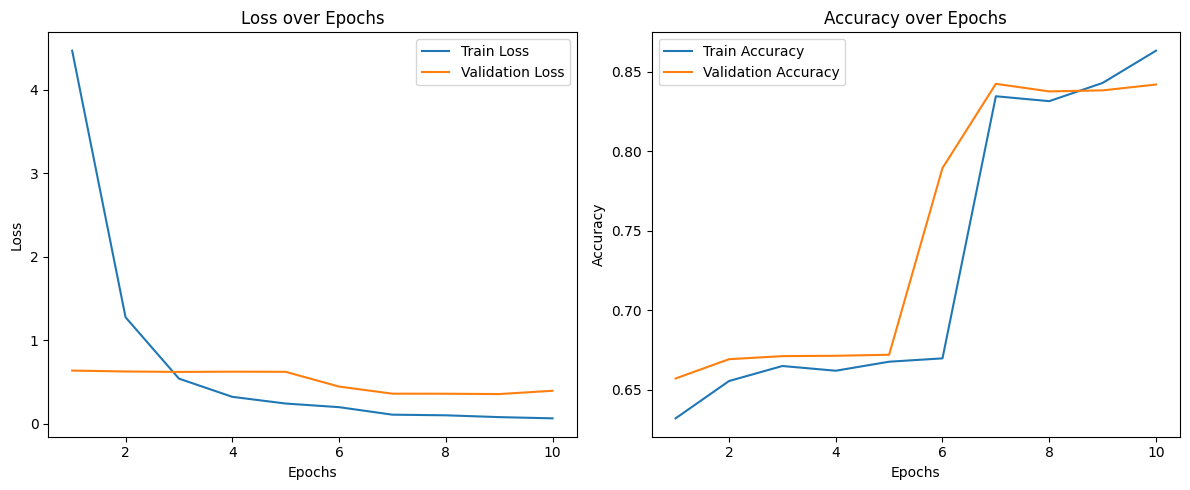

In [ ]:
# Cell 12: Plot Training Curves and Evaluate on Test Data
epochs_range = range(1, len(train_loss_list) + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

joint_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        _, _, class_output = joint_model(texts)
        _, predicted = torch.max(class_output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Joint Model Test Accuracy:", acc)
print("Joint Model Test Precision:", prec)
print("Joint Model Test Recall:", rec)
print("Joint Model Test F1-Score:", f1)